In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import pyspark.sql.functions as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
df_port = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/user/port.csv")

In [3]:
df_counties = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/user/us-counties.csv")

In [46]:
df_seattle_port_trip = df_port.filter(col('city') == 'Seattle').select(col('week_end').cast(DateType()).alias('date'), 'percent_of_trip_volume_change').orderBy('date')
df_seattle_port_trip.show(10)

+----------+-----------------------------+
|      date|percent_of_trip_volume_change|
+----------+-----------------------------+
|2019-01-05|                          0.0|
|2019-01-12|                        58.63|
|2019-01-19|                        -0.99|
|2019-01-26|                        -3.27|
|2019-02-02|                         1.71|
|2019-02-09|                       -12.61|
|2019-02-16|                        -5.84|
|2019-02-23|                        11.59|
|2019-03-02|                        13.84|
|2019-03-09|                        -6.41|
+----------+-----------------------------+
only showing top 10 rows



In [21]:
df_seattle = df_counties.filter(col('state_name') == 'Washington').filter(col('county') == 'King').select(col('date').cast(DateType()).alias('date'), 'confirmed_cases', 'deaths')
df_seattle.show(10)

+----------+---------------+------+
|      date|confirmed_cases|deaths|
+----------+---------------+------+
|2020-08-02|          15529|   676|
|2020-08-03|          15653|   677|
|2020-08-04|          15798|   678|
|2020-08-05|          15965|   678|
|2020-08-06|          16157|   682|
|2020-08-07|          16291|   689|
|2020-08-08|          16491|   694|
|2020-08-09|          16620|   693|
|2020-08-10|          16768|   695|
|2020-08-11|          16849|   698|
+----------+---------------+------+
only showing top 10 rows



In [40]:
window = Window.partitionBy().orderBy('date')
df_seattle_cl = df_seattle.withColumn('confirmed_last', lag('confirmed_cases', 1).over(window))
df_seattle_nc = df_seattle_cl.withColumn('new_confirmed', df_seattle_cl['confirmed_cases'] - df_seattle_cl['confirmed_last'])
df_seattle_nc.show(100)

+----------+---------------+------+--------------+-------------+
|      date|confirmed_cases|deaths|confirmed_last|new_confirmed|
+----------+---------------+------+--------------+-------------+
|2020-02-28|              1|     0|          null|         null|
|2020-02-29|              4|     1|             1|            3|
|2020-03-01|             11|     3|             4|            7|
|2020-03-02|             15|     6|            11|            4|
|2020-03-03|             22|    10|            15|            7|
|2020-03-04|             33|    11|            22|           11|
|2020-03-05|             52|    11|            33|           19|
|2020-03-06|             59|    12|            52|            7|
|2020-03-07|             72|    16|            59|           13|
|2020-03-08|             91|    18|            72|           19|
|2020-03-09|            117|    21|            91|           26|
|2020-03-10|            191|    23|           117|           74|
|2020-03-11|            2

In [41]:
df_seattle_dl = df_seattle_nc.withColumn('deaths_last', lag('deaths', 1).over(window))
df_seattle_nd = df_seattle_dl.withColumn('new_deaths', df_seattle_dl['deaths'] - df_seattle_dl['deaths_last'])
df_seattle_nd.show(10)

+----------+---------------+------+--------------+-------------+-----------+----------+
|      date|confirmed_cases|deaths|confirmed_last|new_confirmed|deaths_last|new_deaths|
+----------+---------------+------+--------------+-------------+-----------+----------+
|2020-02-28|              1|     0|          null|         null|       null|      null|
|2020-02-29|              4|     1|             1|            3|          0|         1|
|2020-03-01|             11|     3|             4|            7|          1|         2|
|2020-03-02|             15|     6|            11|            4|          3|         3|
|2020-03-03|             22|    10|            15|            7|          6|         4|
|2020-03-04|             33|    11|            22|           11|         10|         1|
|2020-03-05|             52|    11|            33|           19|         11|         0|
|2020-03-06|             59|    12|            52|            7|         11|         1|
|2020-03-07|             72|    

In [42]:
df_seattle_final = df_seattle_nd.select('date', 'new_confirmed', 'new_deaths')
df_seattle_final.show(10)

+----------+-------------+----------+
|      date|new_confirmed|new_deaths|
+----------+-------------+----------+
|2020-02-28|         null|      null|
|2020-02-29|            3|         1|
|2020-03-01|            7|         2|
|2020-03-02|            4|         3|
|2020-03-03|            7|         4|
|2020-03-04|           11|         1|
|2020-03-05|           19|         0|
|2020-03-06|            7|         1|
|2020-03-07|           13|         4|
|2020-03-08|           19|         2|
+----------+-------------+----------+
only showing top 10 rows



In [47]:
df_seattle_joined = df_seattle_final.join(df_seattle_port_trip, 'date')
df_seattle_joined.show(10)

+----------+-------------+----------+-----------------------------+
|      date|new_confirmed|new_deaths|percent_of_trip_volume_change|
+----------+-------------+----------+-----------------------------+
|2020-02-29|            3|         1|                         6.76|
|2020-03-07|           13|         4|                       -11.01|
|2020-03-14|           60|         3|                         2.14|
|2020-03-21|          141|         8|                         1.57|
|2020-03-28|          249|        11|                        -0.16|
|2020-04-04|          111|        16|                        -0.02|
|2020-04-11|          145|         7|                         0.71|
|2020-04-18|          161|         9|                        -4.87|
|2020-04-25|          122|         8|                        13.21|
|2020-05-02|           98|         5|                         0.41|
+----------+-------------+----------+-----------------------------+
only showing top 10 rows



In [48]:
df_seattle_pd = df_seattle_joined.toPandas()
df_seattle_pd

,date,new_confirmed,new_deaths,percent_of_trip_volume_change
0,2020-02-29,3,1,6.76
1,2020-03-07,13,4,-11.01
2,2020-03-14,60,3,2.14
3,2020-03-21,141,8,1.57
4,2020-03-28,249,11,-0.16
5,2020-04-04,111,16,-0.02
6,2020-04-11,145,7,0.71
7,2020-04-18,161,9,-4.87
8,2020-04-25,122,8,13.21
9,2020-05-02,98,5,0.41


In [49]:
volumes = np.zeros([39,])
volumes[0] = 100
volumes

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])

In [51]:
for i in range(1, len(volumes)):
    volumes[i] = volumes[i-1] * (1 + df_seattle_pd['percent_of_trip_volume_change'][i]/100)
volumes

array([100.        ,  88.99      ,  90.894386  ,  92.32142786,
        92.17371358,  92.15527883,  92.80958131,  88.2897547 ,
        99.9528313 , 100.36263791, 104.51765112,  99.50080386,
       100.62516295,  96.80140675, 100.3346581 ,  99.58214817,
       101.0161311 , 108.77416997,  95.80828891,  98.56756763,
       103.21010006, 115.60563308, 111.08545283, 103.73159585,
       104.13614907,  91.99387409, 114.15519836, 122.579852  ,
        99.74322557, 106.00710014, 113.30038863, 115.29447547,
       124.18367953, 107.38162769, 112.43930235, 108.33526781,
       112.11616866, 107.41850119, 110.72699103])

In [52]:
df_seattle_pd['trip_volume'] = volumes
df_seattle_pd

,date,new_confirmed,new_deaths,percent_of_trip_volume_change,trip_volume
0,2020-02-29,3,1,6.76,100.000000
1,2020-03-07,13,4,-11.01,88.990000
2,2020-03-14,60,3,2.14,90.894386
3,2020-03-21,141,8,1.57,92.321428
4,2020-03-28,249,11,-0.16,92.173714
5,2020-04-04,111,16,-0.02,92.155279
6,2020-04-11,145,7,0.71,92.809581
7,2020-04-18,161,9,-4.87,88.289755
8,2020-04-25,122,8,13.21,99.952831
9,2020-05-02,98,5,0.41,100.362638


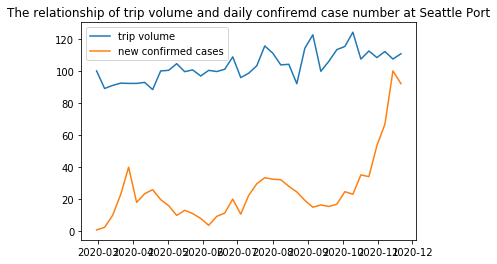

In [53]:
df = df_seattle_pd
plt.plot(df['date'], df['trip_volume'], label='trip volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of trip volume and daily confiremd case number at Seattle Port')
plt.show()